# 02_ocetrac.ipynb
### Use Ocetrac to identify and track MCS objects 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from ocetrac import model as oce

#### Import data files

In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/negative_extremes_OISSTv21.nc',
                  '/burg/abernathey/users/hillary/oisst_v21/preprocessed_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ds

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, time: 478, month: 12)
Coordinates:
  * time              (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lsmask            (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    ssta_notrend      (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_trend        (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mean              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    trend             (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    seas              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_stn_notrend  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend      (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mcs_ssta_notrend  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_stn_trend    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_trend        (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mcs_ssta_trend    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  preprocessed monthly averaged OISST v2.1 anomalies

#### [Optional] Adjust land mask to ignore points poleward of 65ºN and 70ºS

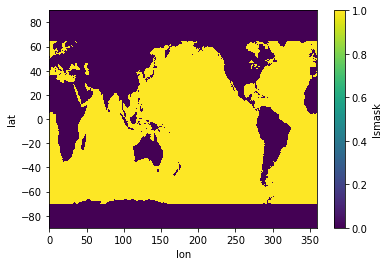

In [3]:
mask = ds.lsmask.where((ds.lat<65) & (ds.lat>-70), drop=False, other=0) 
mask.plot()

### Run Ocetrac

In [40]:
# Set model parameters
da = ds.mcs_ssta_trend.load()*-1 # load the DataArray into memory
# In the next ocetrac release, you shouldn't have to switch signs of da

radius = 8 # radius for structuring element
min_size_quartile = 0.75 # threshold for object areas
timedim = 'time'
xdim = 'lon'
ydim = 'lat'

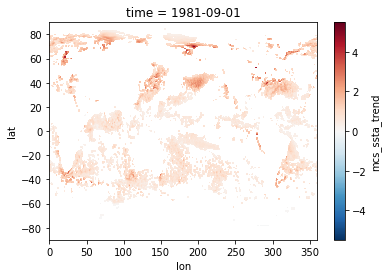

In [41]:
da.isel(time=0).plot()

In [42]:
Tracker =  oce.Tracker(da, mask, radius, min_size_quartile, timedim, xdim, ydim)

In [43]:
%%time 
blobs = Tracker.track()

minimum area:  2477.0
inital objects identified 	 13616
final objects tracked 	 506
CPU times: user 11min 35s, sys: 3min 40s, total: 15min 16s
Wall time: 15min 17s


**The basic output of `Tracker.track` provides:**
- the minimum object area used to filter out MCS that are smaller than this threshold. Area is computed for all objects at each time step. `Ocetrac` looks at the global distribution of object area and finds the size that corresponds to a certain percentile defined by `area_quantile`, which can range from 0.0 to 1.0. Larger values for `area_quantile` exclude more MCS objects and will increase the minimum object area threshold. 
- inital features identified have undergone size thresholding, however are not connected in time. 
- final features tracked are the number of unique MCS objects tracked in space and time. 

#### Let's make a quick plot

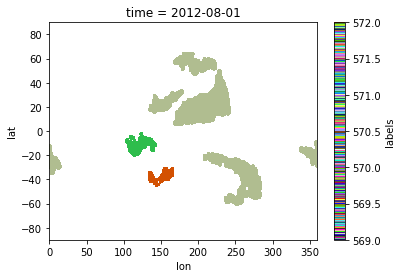

In [38]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

# MCS identified with Ocetrac
blobs.sel(time=('2012-08-01')).plot(cmap= cm)

### Save tracked labels

In [39]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_out = blobs.to_dataset(name='ocetrac_labels')
ds_out.attrs['data'] = 'OISST v2.1 trend'

# Save Dataset to netCDF
ds_out.to_netcdf(path+'ocetrac_MCS_trend.nc', mode='w')